In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [175]:
from implementations import *
from helpers import *
from classifiers import *

In [2]:
from proj1_helpers import *

DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids, features = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)

print(features)

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']


In [68]:
def split_data(X, y=None):
    # features
    undef_feature_for = {
        'DER_deltaeta_jet_jet'   : [0, 1],
        'DER_mass_jet_jet'       : [0, 1],
        'DER_prodeta_jet_jet'    : [0, 1],
        'DER_lep_eta_centrality' : [0, 1],
        'PRI_jet_num'            : [0, 1, 2, 3],
        'PRI_jet_leading_pt'     : [0],
        'PRI_jet_leading_eta'    : [0],
        'PRI_jet_leading_phi'    : [0],
        'PRI_jet_subleading_pt'  : [0, 1],
        'PRI_jet_subleading_eta' : [0, 1],
        'PRI_jet_subleading_phi' : [0, 1],
        'PRI_jet_all_pt'         : [0]
    }

    jet_num_feature = "PRI_jet_num"
    jet_levels = 4

    features_split = []
    for jet in range(jet_levels):
        valid_features = [ f for f in features if not ((f in undef_feature_for) and (jet in undef_feature_for[f])) ]
        features_split.append(valid_features)
        
    # split data based on jet level (vertical split)
    split_indices = [
        X[:,features.index(jet_num_feature)] == i for i in range(jet_levels)
    ]
    X_split = [
        X[X[:,features.index(jet_num_feature)] == i,:] for i in range(jet_levels)
    ]
    if y is None:
        y_split = None
    else:
        y_split = [
            y[X[:,features.index(jet_num_feature)] == i] for i in range(jet_levels)
        ]

    # only keep relevant features (horizontal split)
    for i, X_ in enumerate(X_split):
        indices = [ features.index(feature) for feature in features_split[i] ]
        indices_bool = [ e in indices for e in range(len(features)) ]
        X_split[i] = X_[:,indices_bool]
        
    return split_indices, X_split, y_split

In [211]:
def build_poly_no_interaction(X, degree):
    result = X.copy()
    for d in range(2, degree+1):
        # faster than np.power()
        power = X.copy()
        for i in range(d - 1):
            power = power * X
            
        result = np.hstack((result, power))
        
    return result

def build_X(X, d_int, d_sq):
    """
    Expands X
    
    :param X: examples
    :param d_int: degree of integer powers
    :param d_sq: ceil of degree of half-powers (expansion will be up to d_sq - 0.5)
    
    """
    X_ = remove_NaN_features(X, 0.2)
    X_, mean_, std_ = standardize(X_)
    
    ints = []
    sqrts = []
    
    # build integer powers
    if d_int > 0:
        ints = build_poly_no_interaction(X_, d_int)
      
    # build half-powers (0.5, 1.5, 2.5, etc.)
    if d_sq > 0:
        sqrts = np.sqrt(np.abs(X_))
        if d_sq > 1:
            sqrts = np.c_[sqrts, sqrts * np.abs(build_poly_no_interaction(X_, d_sq - 1))]

    # concat
    X_ = np.c_[ints, sqrts]
    return X_

In [204]:
_, X_split, y_split = split_data(tX, y)

1 - 0.8024675692211434
2 - 0.804423723524172
3 - 0.8074080601545135
4 - 0.807784108675261
5 - 0.8089481483860476
6 - 0.8096562041201141
7 - 0.8103402721255751
8 - 0.8134245468179246
9 - 0.8151727287741669
10 - 0.8154848054573408
11 - 0.8157688400589824
12 - 0.8153088270858204
13 - 0.8094799726467542
14 - 0.8048839584699341


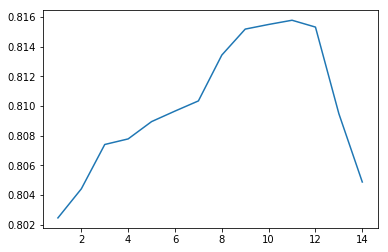

In [212]:
# cross_validate
total_acc = []
k = 10
lambda_ = 0.01
degrees = range(1, 15)

# run that shit
for deg in degrees:
    print(deg, end=" - ")
    X_split_poly = [ build_X(X, deg, 2) for X in X_split ]
    
    accuracies = []
    
    # iterate over 4 sub datasets
    for i in range(len(X_split_poly)):
        classifier = LeastSquaresL2(lambda_)
        acc = np.mean(cross_validate_kfold(y_split[i], X_split_poly[i], classifier, k))
        accuracies.append(acc)
        
    # compute mean (weighted)
    accuracy = 0
    for i, acc in enumerate(accuracies):
        accuracy += acc * len(y_split[i])
    accuracy /= len(y)
        
    print(accuracy)
    total_acc.append(accuracy)
    
plt.plot(degrees, total_acc)

In [208]:
# train actual models
# degree 9 seems to be best

X_split_poly = [ build_X(X, 9, 2) for X in X_split ]
lambda_ = 0.01
models = []
for i in range(len(X_split_poly)):
    print(f"Building model for dataset {i}")
    lse = LeastSquaresL2(lambda_)
    lse.fit(y_split[i], X_split_poly[i])
    models.append(lse)

Building model for dataset 0
Building model for dataset 1
Building model for dataset 2
Building model for dataset 3


In [205]:
# testing regularized logistic regression 
# seems to be absolute shit for this 
classifier = LogisticRegressionL2(0.01, verbose=True, max_evaluations=400)
classifier.fit(y_split[0], X_split_poly[0])
np.mean(y_split[0] == classifier.predict(X_split_poly[0]))

f_new: 76658898567251466163194953728.000 - f: 69254.414 - Backtracking...
f_new: 38329449283176485824627736576.000 - f: 69254.414 - Backtracking...
f_new: 19164724641363614885782487040.000 - f: 69254.414 - Backtracking...
f_new: 9582362320569493429625552896.000 - f: 69254.414 - Backtracking...
f_new: 4791181160228590807691558912.000 - f: 69254.414 - Backtracking...
f_new: 2395590580086217725163077632.000 - f: 69254.414 - Backtracking...
f_new: 1197795290029069748362280960.000 - f: 69254.414 - Backtracking...
f_new: 598897645007515248352034816.000 - f: 69254.414 - Backtracking...
f_new: 299448822500247879980941312.000 - f: 69254.414 - Backtracking...
f_new: 149724411248369067892932608.000 - f: 69254.414 - Backtracking...
f_new: 74862205623307097897697280.000 - f: 69254.414 - Backtracking...
f_new: 37431102811214830924464128.000 - f: 69254.414 - Backtracking...
f_new: 18715551405388056450039808.000 - f: 69254.414 - Backtracking...
f_new: 9357775702584346571440128.000 - f: 69254.414 - Bac

164 - loss: 69252.547
f_new: 69441.077 - f: 69252.547 - Backtracking...
166 - loss: 69252.547
f_new: 69433.048 - f: 69252.547 - Backtracking...
168 - loss: 69252.547
f_new: 69425.296 - f: 69252.547 - Backtracking...
170 - loss: 69252.547
f_new: 69417.839 - f: 69252.547 - Backtracking...
172 - loss: 69252.547
f_new: 69410.690 - f: 69252.547 - Backtracking...
174 - loss: 69252.547
f_new: 69403.855 - f: 69252.547 - Backtracking...
176 - loss: 69252.547
f_new: 69397.336 - f: 69252.547 - Backtracking...
178 - loss: 69252.546
f_new: 69391.131 - f: 69252.546 - Backtracking...
180 - loss: 69252.546
f_new: 69385.233 - f: 69252.546 - Backtracking...
182 - loss: 69252.546
f_new: 69379.633 - f: 69252.546 - Backtracking...
184 - loss: 69252.546
f_new: 69374.322 - f: 69252.546 - Backtracking...
186 - loss: 69252.546
f_new: 69369.287 - f: 69252.546 - Backtracking...
188 - loss: 69252.546
f_new: 69364.516 - f: 69252.546 - Backtracking...
190 - loss: 69252.546
f_new: 69359.995 - f: 69252.546 - Backtrac

398 - loss: 69252.544
f_new: 69256.496 - f: 69252.544 - Backtracking...
400 - loss: 69252.544
Reached maximum number of function evaluations 400


0.3692912834165724

## Do your thing crazy machine learning thing here :) ...

In [66]:
kernel = LeastSquaresKernel(Kernel.kernel_poly, verbose=True, max_evals=300)
p = 4
lambda_ = 0
incr = 40
incr_pred = 30
pred = kernel.predict(y[::incr], X__[::incr], X__[::incr_pred], p, lambda_=lambda_)
print(np.mean(y[::incr_pred] == pred))

0.543932


In [5]:
X = replace_NaN_by_median(X)
X, _, _ = standardize(X)

In [6]:
X_sub = X[::30]
y_sub = y[::30]

In [16]:
logReg = LogisticRegression(verbose=True, max_evaluations=1000)
logReg.fit(y_sub, np.c_[np.ones(X_sub.shape[0]), X_sub])
pred = logReg.predict(np.c_[np.ones(X_sub.shape[0]), X_sub])
print(compute_accuracy(pred, y_sub))

f_new: 351332120652.464 - f: 5776.689 - Backtracking...
f_new: 49908376999.952 - f: 5776.689 - Backtracking...
f_new: 7089719742.161 - f: 5776.689 - Backtracking...
f_new: 1007128546.313 - f: 5776.689 - Backtracking...
f_new: 143067923.558 - f: 5776.689 - Backtracking...
f_new: 20324057.388 - f: 5776.689 - Backtracking...
f_new: 2887715.309 - f: 5776.689 - Backtracking...
f_new: 410801.817 - f: 5776.689 - Backtracking...
f_new: 58949.841 - f: 5776.689 - Backtracking...
f_new: 9667.717 - f: 5776.689 - Backtracking...
11 - loss: 5549.281
12 - loss: 5405.800
13 - loss: 5352.943
14 - loss: 5260.879
15 - loss: 5057.649
f_new: 5188.842 - f: 5057.649 - Backtracking...
17 - loss: 5042.088
18 - loss: 5030.287
19 - loss: 5022.815
20 - loss: 4723.083
f_new: 5530.003 - f: 4723.083 - Backtracking...
22 - loss: 4714.058
23 - loss: 4702.917
24 - loss: 4700.799
25 - loss: 4698.556
26 - loss: 4630.235
27 - loss: 4608.311
f_new: 4631.497 - f: 4608.311 - Backtracking...
29 - loss: 4598.083
30 - loss: 459

400 - loss: 4446.114
401 - loss: 4446.114
402 - loss: 4446.112
403 - loss: 4439.172
f_new: 6378.863 - f: 4439.172 - Backtracking...
405 - loss: 4439.165
406 - loss: 4439.154
407 - loss: 4439.154
408 - loss: 4439.154
409 - loss: 4439.151
410 - loss: 4439.148
411 - loss: 4439.077
f_new: 4439.109 - f: 4439.077 - Backtracking...
413 - loss: 4439.072
414 - loss: 4439.067
415 - loss: 4439.067
416 - loss: 4439.066
417 - loss: 4438.991
418 - loss: 4438.892
419 - loss: 4438.888
f_new: 4438.888 - f: 4438.888 - Backtracking...
421 - loss: 4438.887
422 - loss: 4438.887
423 - loss: 4438.887
424 - loss: 4438.884
425 - loss: 4438.881
426 - loss: 4438.876
427 - loss: 4438.798
428 - loss: 4438.691
429 - loss: 4438.690
430 - loss: 4438.689
431 - loss: 4438.689
432 - loss: 4438.688
433 - loss: 4438.685
434 - loss: 4438.682
435 - loss: 4438.675
436 - loss: 4438.674
437 - loss: 4438.674
438 - loss: 4438.674
439 - loss: 4438.644
440 - loss: 4438.614
441 - loss: 4438.574
442 - loss: 4438.573
443 - loss: 4438

818 - loss: 4417.337
819 - loss: 4417.337
820 - loss: 4417.337
821 - loss: 4417.236
822 - loss: 4417.145
f_new: 4417.199 - f: 4417.145 - Backtracking...
824 - loss: 4417.145
825 - loss: 4417.145
826 - loss: 4417.145
827 - loss: 4417.140
828 - loss: 4417.134
829 - loss: 4417.132
830 - loss: 4417.130
831 - loss: 4417.129
832 - loss: 4417.128
833 - loss: 4417.128
834 - loss: 4417.128
835 - loss: 4417.107
836 - loss: 4417.087
837 - loss: 4417.085
838 - loss: 4417.085
839 - loss: 4417.085
840 - loss: 4417.084
841 - loss: 4417.083
842 - loss: 4417.081
843 - loss: 4417.059
844 - loss: 4416.973
845 - loss: 4416.972
846 - loss: 4416.972
847 - loss: 4416.972
848 - loss: 4416.971
849 - loss: 4416.969
850 - loss: 4416.967
851 - loss: 4416.958
852 - loss: 4416.943
853 - loss: 4416.941
854 - loss: 4416.941
855 - loss: 4416.941
856 - loss: 4416.941
857 - loss: 4416.908
858 - loss: 4416.869
859 - loss: 4416.867
860 - loss: 4416.866
861 - loss: 4416.865
862 - loss: 4416.865
863 - loss: 4416.865
864 - l

In [9]:
#kernel_logreg_poly = LeastSquaresGDKernel(Kernel.kernel_poly, verbose=True, max_evals=1000)
#kernel_logreg_poly = LogisticRegressionKernel(Kernel.kernel_poly, verbose=True, max_evals=1000)
kernel_logreg_poly = LogisticRegressionKernel(Kernel.kernel_poly, verbose=True, max_evals=1000)
p = 4
preds = kernel_logreg_poly.predict(y_sub, X_sub, X_sub, p)
print(compute_accuracy(preds, y_sub))

f_new: 388952141074152048493827070704946719003374518272.000 - f: 0.693 - Backtracking...
f_new: 42948940344232256197308449618584789201601953792.000 - f: 0.693 - Backtracking...
f_new: 4742515291465520316589241094131375336488697856.000 - f: 0.693 - Backtracking...
f_new: 523678840723825601365942021904012656230006784.000 - f: 0.693 - Backtracking...
f_new: 57825755188467729788181246775209813142929408.000 - f: 0.693 - Backtracking...
f_new: 6385245503703762415557669590722242188148736.000 - f: 0.693 - Backtracking...
f_new: 705072679287725974358492902368409655705600.000 - f: 0.693 - Backtracking...
f_new: 77855656887368529251737837091182763573248.000 - f: 0.693 - Backtracking...
f_new: 8596990760565376003751822352078876966912.000 - f: 0.693 - Backtracking...
f_new: 949298395159228346089345013828158488576.000 - f: 0.693 - Backtracking...
f_new: 104823590969245276918563331445266317312.000 - f: 0.693 - Backtracking...
f_new: 11574848624751544723633017999918628864.000 - f: 0.693 - Backtracking

285 - loss: 0.661
286 - loss: 0.661
287 - loss: 0.661
288 - loss: 0.661
f_new: 0.661 - f: 0.661 - Backtracking...
290 - loss: 0.661
291 - loss: 0.661
292 - loss: 0.661
293 - loss: 0.661
294 - loss: 0.661
f_new: 0.661 - f: 0.661 - Backtracking...
296 - loss: 0.661
297 - loss: 0.661
298 - loss: 0.661
299 - loss: 0.661
300 - loss: 0.660
301 - loss: 0.660
302 - loss: 0.660
303 - loss: 0.660
304 - loss: 0.660
305 - loss: 0.660
306 - loss: 0.660
307 - loss: 0.660
308 - loss: 0.660
309 - loss: 0.660
310 - loss: 0.660
311 - loss: 0.660
312 - loss: 0.660
313 - loss: 0.660
314 - loss: 0.660
315 - loss: 0.660
316 - loss: 0.660
317 - loss: 0.660
318 - loss: 0.660
319 - loss: 0.660
320 - loss: 0.660
321 - loss: 0.660
322 - loss: 0.660
323 - loss: 0.660
324 - loss: 0.660
f_new: 0.660 - f: 0.660 - Backtracking...
326 - loss: 0.660
327 - loss: 0.660
328 - loss: 0.660
329 - loss: 0.660
330 - loss: 0.660
331 - loss: 0.660
332 - loss: 0.660
333 - loss: 0.660
334 - loss: 0.660
335 - loss: 0.660
336 - loss

698 - loss: 0.649
699 - loss: 0.649
700 - loss: 0.649
701 - loss: 0.649
f_new: 0.649 - f: 0.649 - Backtracking...
703 - loss: 0.649
704 - loss: 0.649
705 - loss: 0.649
706 - loss: 0.649
707 - loss: 0.649
708 - loss: 0.649
709 - loss: 0.649
710 - loss: 0.649
711 - loss: 0.649
712 - loss: 0.649
713 - loss: 0.649
714 - loss: 0.649
715 - loss: 0.649
716 - loss: 0.649
717 - loss: 0.649
718 - loss: 0.649
719 - loss: 0.649
f_new: 0.649 - f: 0.649 - Backtracking...
721 - loss: 0.649
722 - loss: 0.649
723 - loss: 0.649
724 - loss: 0.649
725 - loss: 0.649
726 - loss: 0.649
727 - loss: 0.649
728 - loss: 0.649
729 - loss: 0.649
730 - loss: 0.649
731 - loss: 0.649
732 - loss: 0.647
f_new: 0.663 - f: 0.647 - Backtracking...
734 - loss: 0.647
735 - loss: 0.647
736 - loss: 0.647
737 - loss: 0.647
738 - loss: 0.647
739 - loss: 0.647
f_new: 0.647 - f: 0.647 - Backtracking...
741 - loss: 0.647
742 - loss: 0.647
743 - loss: 0.647
744 - loss: 0.647
745 - loss: 0.647
f_new: 0.647 - f: 0.647 - Backtracking..

In [ ]:
tX_clean = remove_NaN_features(tX, 0.20)

In [ ]:
logReg = LogisticRegression()
logReg.fit(y, tX_clean)

In [36]:
model = AlternativePCA(k=2)
model.fit(X)
Z_pca = model.compress(X)
Xhat_pca = model.expand(Z_pca)

Iteration 0, loss = 1289883598.7
Iteration 1, loss = 929278938.1
Iteration 2, loss = 843606874.7
Iteration 3, loss = 832528308.0
Iteration 4, loss = 831415267.7
Iteration 5, loss = 831306045.8
Iteration 6, loss = 831295253.7
Iteration 7, loss = 831294167.6
Iteration 8, loss = 831294054.6
Iteration 9, loss = 831294042.1


In [25]:
model = RobustPCA(k=2)
model.fit(X)
Z_robust = model.compress(X)
Xhat_robust = model.expand(Z_robust)

Iteration 0, loss = 1521186763.4
Iteration 1, loss = 947138369.7
Iteration 2, loss = 854324275.1
Iteration 3, loss = 835473177.5
Iteration 4, loss = 832070513.0
Iteration 5, loss = 831441985.7


C:\Users\antho\Google Drive\EPFL\MA1\CS-433 Machine Learning\ML_course\projects\project1\scripts\solver.py:65: RuntimeWarning: invalid value encountered in double_scalars
  y = g_new - g


Iteration 6, loss = 831322662.2
Iteration 7, loss = 831299623.4
Iteration 8, loss = 831295133.9
Iteration 9, loss = 831294255.0
Iteration 0, loss = 114368921.2
Iteration 1, loss = 114357028.3
Iteration 2, loss = 114357025.0
Iteration 3, loss = 114357025.0
Iteration 4, loss = 114357025.0
Iteration 5, loss = 114357025.0
Iteration 6, loss = 114357025.0
Iteration 7, loss = 114357025.0
Iteration 8, loss = 114357025.0
Iteration 9, loss = 114357025.0


In [37]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from matplotlib.colors import Normalize

#Need to rescale to do PCA
def pca_axes(Z,scale,scale2, verbose=False):
    
    pcs = 
    colors = np.arctan2(pcs[0,:], pcs[1,:])
    colormap = cm.inferno
    norm = Normalize()
    norm.autoscale(colors)
    plt.rcParams['image.cmap'] = 'Paired'

    # Quiver
    fig = plt.figure(figsize=(10,10))
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
           pcs[0,:], pcs[1,:], color=colormap(norm(colors)),
           angles='xy', scale_units='xy', scale=scale)
    o = 0
    for i in range(0,pcs.shape[1]):
        #plt.arrow(0, 0, pcs[0,i], pcs[1,i],color='k') 
        if i==3:
            plt.text(pcs[0,i]* scale2, pcs[1,i]*scale2-0.03, X.columns[i], color = 'k', 
             ha = 'center', va = 'center', fontsize=10, weight='bold')
        elif i==12:
            plt.text(pcs[0,i]* scale2, pcs[1,i]*scale2-0.03, X.columns[i], color = 'k', 
             ha = 'center', va = 'center', fontsize=10, weight='bold')
        elif np.power(pcs[0,i]-pcs[1,i], 2)<0.001:
            plt.text(0, 0-o, ' ', color = 'k', 
             ha = 'center', va = 'center', fontsize=12, weight='bold')
        else:
            plt.text(pcs[0,i]* scale2, pcs[1,i] *scale2, X.columns[i], color = 'k', 
             ha = 'center', va = 'center', fontsize=10, weight='bold')
        o=o+0.04

    plt.axis('equal')
    plt.xlim([-1.0,1.0])
    plt.ylim([-0.5,1.0])
    plt.xlabel('Principal component 0')
    plt.ylabel('Principal component 1')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
 
    if verbose==True:
        for i in range (0,pcs.shape[1]):
            print(str(i), df.columns[i+2])
        
    return

pca_axes(Z_pca, 0.65, 1.7)

array([[ 4.72588088, -7.31380373],
       [ 3.89450982, 10.60756305],
       [ 7.77930283, -1.90683368],
       ...,
       [-2.54520707,  6.4204025 ],
       [-8.07558037, 21.54278193],
       [-4.59888286, 21.69639677]])

In [15]:
# test kernel
kernel_logreg_poly = LeastSquaresKernel(Kernel.kernel_RBF, verbose=True, max_evals=1000)
p = 4
sigma = 1
accuracies = []
for i in range(5):
    print(i,  end=' - ')
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    X_sub = (X[shuffle_indices,:])[::100]
    y_sub = (y[shuffle_indices])[::100]
    
    X_pred = (X[shuffle_indices,:])[::100]
    y_pred = (y[shuffle_indices])[::100]
    
    preds = kernel_logreg_poly.predict(y_sub, X_sub, X_pred, sigma, lambda_=1)
    accuracy = compute_accuracy(preds, y_pred)
    accuracies.append(accuracy)
    print(accuracy)
    

0 - 

KeyboardInterrupt: 

In [34]:
np.mean(accuracies)

0.8757090909090909

In [ ]:
w_mse, loss_mse = least_squares(y, X)

In [ ]:
accuracy_mse = compute_accuracy(predict_labels(w_mse, X), y)
print(accuracy_mse)

In [ ]:
def ridge_classifier(lambda_):
    return ridge_regression(y, X, lambda_)

lambda_ridge, _, _ = find_max_hyperparam(ridge_classifier, [10**c for c in range(-3,3)])
print("Optimal lambda: %f" % lambda_ridge)

In [ ]:
def ridge_train(y_train, X_train):
    return ridge_regression(y, X, lambda_ridge)

def ridge_test(X_test, w):
    return np.sign(X_test@w)

accuracy_ridge = cross_validate(y, X, ridge_train, ridge_test, 0.8, 100)
print(accuracy_ridge)

In [ ]:
def log_reg_train(y_train, X_train):
    return logistic_regression(y_train, X_train, 0.01*np.ones(X_train.shape[1]), 1000, verbose=False)

def log_reg_test(X_test, w):
    return np.sign(X_test@w)

accuracy_log_reg = cross_validate(y, X_safe, log_reg_train, log_reg_test, 0.7, 20)
print(accuracy_log_reg)

In [ ]:
def reg_log_reg_classifier(lambda_):
    return reg_logistic_regression(y, X_safe, lambda_, np.zeros(X_safe.shape[1]), 1000)

def log_reg_sparse_classifier(lambda_):
    return logistic_regression_sparse(y, X_safe, lambda_, np.zeros(X_safe.shape[1]), 1000)

def mse_sparse_classifier(lambda_):
    return least_squares_sparse(y, X_safe, lambda_, np.zeros(X_safe.shape[1]), 1000)

In [ ]:
lambda_log_reg_l2, _, _ = find_max_hyperparam(reg_log_reg_classifier, [10**c for c in range(-3,3)])

In [ ]:
lambda_log_reg_l1, _, _ = find_max_hyperparam(log_reg_sparse_classifier, [10**c for c in range(-3,3)])

In [ ]:
lambda_mse_l2, _, _ = find_max_hyperparam(ridge_classifier, [10**c for c in range(-6,1)])

In [ ]:
lambda_mse_l1, w_mse_l1, _ = find_max_hyperparam(mse_sparse_classifier, [10**c for c in range(-6,1)])

In [ ]:
w_mse_l1, _ = least_squares_sparse(y, X_safe, 0.01, np.zeros(X_safe.shape[1]), 1000)
print("Non-zero weights: %i / %i" % (np.sum(w_mse_l1 != 0), len(w_mse_l1)))

In [ ]:
p = 1
ypred_kernel = kernel_predict(kernel_poly, y, X_safe, X_safe, p, lambda_=1)
print(compute_accuracy(ypred_kernel, y))

## Generate predictions and save ouput in csv format for submission:

In [20]:
DATA_TEST_PATH = '../data/test.csv'
y_test, tX_test, ids_test, _ = load_csv_data(DATA_TEST_PATH)

In [187]:
# predictions using new model
test_split_indices, X_test_split, _ = split_data(tX_test)
X_test_split_poly = [ build_X(X, 8, 2) for X in X_test_split ]
y_pred = np.ones(tX_test.shape[0])
for model, X, indices in zip(models, X_test_split_poly, test_split_indices):
    y_pred[indices] = model.predict(X)

In [188]:
OUTPUT_PATH = '../results/predictions.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
OUTPUT_PATH = '../results/predictions.csv'
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)